Proyecto DS4A- E- COMMERCE

In [2]:
# Import the Pandas package
import pandas as pd

# Import the NumPy package
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata as unicode
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests

## 1. Import Datasets 

In [3]:
customers_dataset = pd.read_csv("data/olist_customers_dataset.csv")#
geolocation_dataset = pd.read_csv("data/olist_geolocation_dataset.csv")
order_items_dataset = pd.read_csv("data/olist_order_items_dataset.csv")#
#order_payments_dataset = pd.read_csv("data/olist_order_payments_dataset.csv")
order_reviews_dataset = pd.read_csv("data/olist_order_reviews_dataset.csv")#
orders_dataset = pd.read_csv("data/olist_orders_dataset.csv")#
products_dataset = pd.read_csv("data/olist_products_dataset.csv")#
seller_dataset = pd.read_csv("data/olist_sellers_dataset.csv")#
product_category_name_translation = pd.read_csv("data/product_category_name_translation.csv")#


![Captura.PNG](attachment:Captura.PNG)

data set that contain the id, unique id, the zip code, the citya and the state of the costumer


## 2. join the data sets and creade stadistics KPI'S


In [4]:
df_orders = pd.merge(customers_dataset,orders_dataset, how = "left", left_on = "customer_id", right_on = "customer_id")
df_orders = pd.merge(df_orders,order_reviews_dataset, how = "left", left_on = "order_id", right_on = "order_id")
#df_orders = pd.merge(mg_dataset2,seller_dataset,how = "left", left_on = "seller_id", right_on = "seller_id")
#mg_dataset2 = pd.merge(mg_dataset1,order_payments_dataset, how = "left", left_on ="order_id",right_on ="order_id")
#mg_dataset3 = pd.merge(mg_dataset2,order_reviews_dataset, how = "left", left_on = "order_id", right_on = "order_id")
#mg_dataset4 = pd.merge(mg_dataset3,order_items_dataset,how = "left", left_on = "order_id", right_on = "order_id")
#mg_dataset5 = pd.merge(mg_dataset4,products_dataset,how = "left", left_on = "product_id", right_on = "product_id")
#df = pd.merge(mg_dataset5,seller_dataset,how = "left", left_on = "seller_id", right_on = "seller_id")
#df = pd.merge(mg_dataset6,geolocation_dataset, how = "left", left_on = "customer_zip_code_prefix", right_on = "geolocation_zip_code_prefix")
df_items=pd.merge(order_items_dataset,products_dataset,how='left',left_on='product_id',right_on='product_id')
df_items=pd.merge(df_items,product_category_name_translation,how='left',left_on='product_category_name',right_on='product_category_name')
df_items=pd.merge(df_items,seller_dataset,how='left',left_on='seller_id',right_on='seller_id')



In [5]:


geolocation_dataset['geolocation_city']=geolocation_dataset['geolocation_city'].apply(lambda x: unicode.normalize('NFKD',x).encode("ascii","ignore").decode("ascii"))
geolocation_dataset['geolocation_city'].unique()


array(['sao paulo', 'sao bernardo do campo', 'jundiai', ...,
       'floriano peixoto', 'erebango', 'santa cecilia do sul'], dtype=object)

In [6]:
maxlat=5.25
minlat=-33.75
minlng=-74
maxlng=-29
geolocation_dataset=geolocation_dataset.drop(geolocation_dataset[(geolocation_dataset['geolocation_lat']>maxlat) | (geolocation_dataset['geolocation_lat']<minlat)|(geolocation_dataset['geolocation_lng']>maxlng) | (geolocation_dataset['geolocation_lng']<minlng)].index)
df_geo=geolocation_dataset.groupby('geolocation_zip_code_prefix').aggregate({'geolocation_lat':'mean','geolocation_lng':'mean'})
temp=geolocation_dataset.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state']).count().reset_index()

df_geo=df_geo.merge(temp[['geolocation_zip_code_prefix','geolocation_city','geolocation_state']],how='left',on='geolocation_zip_code_prefix')
df_geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1001,-23.550190,-46.634024,sao paulo,SP
1,1002,-23.548146,-46.634979,sao paulo,SP
2,1003,-23.548994,-46.635731,sao paulo,SP
3,1004,-23.549799,-46.634757,sao paulo,SP
4,1005,-23.549456,-46.636733,sao paulo,SP


In [7]:
df_orders=df_orders.merge(df_geo,how='left',right_on='geolocation_zip_code_prefix',left_on='customer_zip_code_prefix')
df_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,14409.0,-20.498489,-47.396929,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,9790.0,-23.727992,-46.542848,sao bernardo do campo,SP


In [8]:
df_items=df_items.merge(df_geo,how='left',right_on='geolocation_zip_code_prefix',left_on='seller_zip_code_prefix')
df_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_length,...,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,...,14.0,cool_stuff,27277,volta redonda,SP,27277.0,-22.496953,-44.127492,volta redonda,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,pet_shop,56.0,239.0,...,40.0,pet_shop,3471,sao paulo,SP,3471.0,-23.565096,-46.518565,sao paulo,SP


In [9]:
df_items=df_items.merge(df_orders[['order_id','geolocation_lat','geolocation_lng']],how='left',on='order_id')
import math as math
def distancia(row):
    lat1=row['geolocation_lat_x']
    lat2=row['geolocation_lat_y']
    lng1=row['geolocation_lng_x']
    lng2=row['geolocation_lng_y']
    R_earth=6371
    dlat=math.radians(lat2-lat1)
    dlng=math.radians(lng2-lng1)
    a= (math.sin(dlat/2))**2+math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*((math.sin(dlng/2))**2)
    c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
    return R_earth*c

df_items['distance']=df_items.apply(lambda x:distancia(x),axis=1)
df_items["LIMIT_DATE"] = pd.to_datetime(df_items["shipping_limit_date"])
df_orders['order_estimated_delivery_date']=pd.to_datetime(df_orders['order_estimated_delivery_date'])
temp=df_items.groupby('order_id').agg({'product_id':'count','LIMIT_DATE':'max','distance':'max'}).reset_index()
temp.columns=['order_id','Q_products','Shipping_due_date','Distance']
df_orders=df_orders.merge(temp,how='left',on='order_id')


In [10]:
df_items["LIMIT_DATE"] = pd.to_datetime(df_items["shipping_limit_date"])
df_orders['order_estimated_delivery_date']=pd.to_datetime(df_orders['order_estimated_delivery_date'])
df_orders['order_delivered_customer_date']=pd.to_datetime(df_orders['order_delivered_customer_date'])
df_orders['Fulfill_date']= df_orders['order_delivered_customer_date']<df_orders['order_estimated_delivery_date']

Hasta aca quedaron dos tablas:

**df_ orders** que tiene un registro por cada compra en olist y dentro tiene:

1. Informacion de la orden
2. Informacion del cliente
3. Informacion del Review del cliente
4. Georeferenciacion del cliente

**df_items** que tiene un registro por cada item que se ha despachado y dentro tiene:

1. Informacion de cada producto
2. Numero de Orden  a la que esta relacionada
3. Informacion del vendedor (Cada item es despachada por un unico vendedor, pero una orden puede ser despachada por varios vendedores)
4. Georeferenciacion del vendedor

La informacion de **georeferenciacion** llega solo al zipcode del comprador y del vendedor, parece que le eliminaron la direccion, pero dejaron las coordenadas, por lo que incluir esta informacion hace que los registros se repitan la cantidad de clientes+vendedores que existan en el mismo zipcode

La informacion de pagos creo que puede ser relevante, pero tiene el problema de que el cliente puede hacer el pago con mas de un metodo, al final creo que la informacion relevante es que medio uso (solo hay 4 o 5 medios) y puede que tambien sea relevante en cuantas partes dividio el pago (numero maximo de payment_sequential)


**Sugerencia1**: En la tabla de reviews, hay ordenes que tienen mas de un review, debemos limpiarla y dejar el ultimo por fecha de registro del review (el cliente pudo cambiar de opinion o contestar la encuesta varias veces)

**Sugerencia 2**: Hacer con los pagos 5 variables categoricas para determinar los medios de pago que utilizo el cliente en cada ordes, agregar el numero de payments con el max de payment_sequential y llevar estas 6 variables a la tabla df_orders

In [11]:
df_orders.info() # Entendimiento de las variables.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103712 entries, 0 to 103711
Data columns (total 27 columns):
customer_id                      103712 non-null object
customer_unique_id               103712 non-null object
customer_zip_code_prefix         103712 non-null int64
customer_city                    103712 non-null object
customer_state                   103712 non-null object
order_id                         103712 non-null object
order_status                     103712 non-null object
order_purchase_timestamp         103712 non-null object
order_approved_at                103547 non-null object
order_delivered_carrier_date     101867 non-null object
order_delivered_customer_date    100631 non-null datetime64[ns]
order_estimated_delivery_date    103712 non-null datetime64[ns]
review_id                        103712 non-null object
review_score                     103712 non-null int64
review_comment_title             12182 non-null object
review_comment_message           433

Revisando la información de las variables que componen el Data Frame, nos damos cuenta que order_delivered_carrier_date,order_delivered_customer_date,review_comment_title y review_comment_message presentan valores NA dentro de sus columnas. adempas que tenemos un total de 100.000 registros unicos en la base haciendo referencia a las compras que hicieron los clientes


      DATE  customer_unique_id
0  2016-09                   4
1  2016-10                 336
2  2016-12                   1
3  2017-01                 843
4  2017-02                1849
5  2017-03                2790
6  2017-04                2507
7  2017-05                3862
8  2017-06                3377
9  2017-07                4201
10 2017-08                4532
11 2017-09                4466
12 2017-10                4840
13 2017-11                7908
14 2017-12                5944
15 2018-01                7608
16 2018-02                7056
17 2018-03                7531
18 2018-04                7193
19 2018-05                7152
20 2018-06                6403
21 2018-07                6552
22 2018-08                6737
23 2018-09                  16
24 2018-10                   4


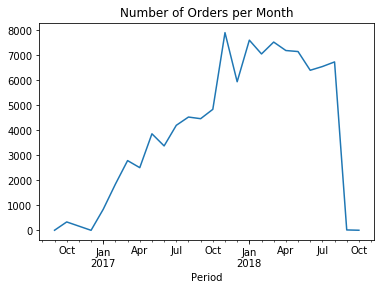

In [12]:
#Grafica del numero de ordenes por mes de análisis
df_orders["DATE"] = pd.to_datetime(df_orders["order_purchase_timestamp"])
df_orders["DATE"] = df_orders["DATE"].dt.to_period(freq = "M")

orders_by_month = df_orders.groupby('DATE')['customer_unique_id'].count().reset_index(drop = False)
print(orders_by_month)

#Line Plot for the Colission by date.

# Modificación Emmanuel G para embellecer las gráficas
# Inicio (1)
orders_by_month.plot(x= "DATE",y="customer_unique_id",title="Number of Orders per Month")
plt.xlabel("Period")    
plt.legend('',frameon=False)
#Fin (1)

Creación de una variable que calcule el tiempo que se demora en entregar un producto desde que se realizó la compra por la plataforma, pues puede ser una variable explicativa del socore de los clientes.


In [13]:
#CREACIÓN DE UNA VARIABLE DEL TIEMPO ENTRE COMPRA Y ENTREGA DE PRODUCTO
# Then with the remaining values, convert them to datetime objects
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'], format='%Y/%m/%d %H:%M:%S')
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], format='%Y/%m/%d %H:%M:%S')

df_orders['time_duration'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp'])
df_orders['time_duration'] = df_orders['time_duration'].apply(lambda x: x.days)
# At this point, its important to know the time duration since customer purchase and delivery.

# Modificación de Emmanuel G para embellecer
#Inicio (2)
df_describe = pd.DataFrame(df_orders['time_duration'].describe())
df_describe.columns = {'Time Duration'}
df_describe
#Fin (2)

,Time Duration
count,100631.000000
mean,12.123610
std,9.574398
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,209.000000


Como se evidencia en el resultado anterior, el promedio de dias que toma un producto en ser entregado desde el día de compra es de 12 dias. Lo importante aquí es que se encontró que el valor maximo de tiempo de duración es de 209 dias, al rededor de 7 meses, algo bastante extraño y que ahondaremos más adelante.


[Text(0,0.5,'# Customers (Unique)'),
 Text(0.5,0,'Time Duration'),
 Text(0.5,1,'Number of curstomers (Unique) Vs Time Duration')]

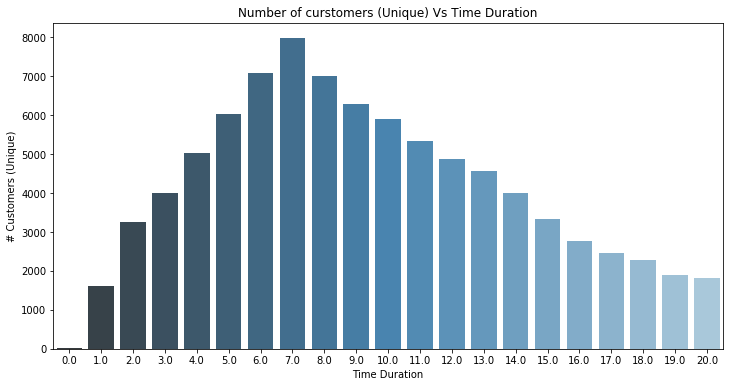

In [14]:
df_subset= df_orders[df_orders.time_duration <= 20]
df_by_duration = df_subset.groupby(['time_duration'])['customer_unique_id'].count().reset_index(drop = False)

#Modificación de Emmanuel G para embellecer
#Inicio(3) 
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.barplot(ax=ax
                , x="time_duration"
                , y="customer_unique_id"
                , data=df_by_duration
                , palette="Blues_d"                
               )
g.set(xlabel = 'Time Duration', ylabel = '# Customers (Unique)', title="Number of curstomers (Unique) Vs Time Duration")
#Fin(3)

Evidenciamos que la distribución al rededor de la grafica se concentra en los periodos comprendidos entre 0 y 7 dias de demora en entrega del producto, y continua decendiendo. ahora bien esto nos puede dar indicios queel promedio de demora no suele ser superior a los 7 dias para el promedio de datos de toda la base, pero es relevante compararlo con los scores en reviews para poder identificar algún patrón.

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


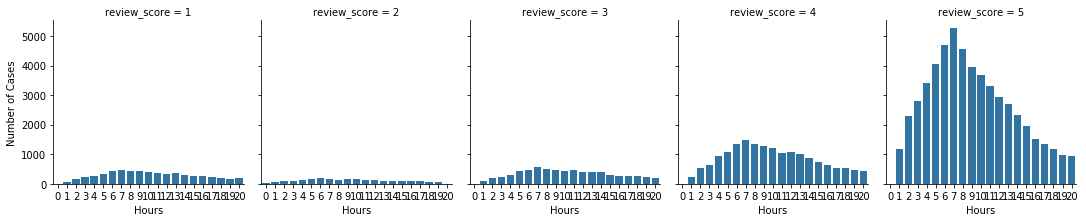

In [15]:
df_subset= df_orders[df_orders.time_duration <= 20]
df_subset.time_duration = df_subset.time_duration.astype(int)
df_by_duration = df_subset.groupby(['time_duration','review_score'])['customer_unique_id'].count().reset_index(drop = False)
g = sns.FacetGrid(df_by_duration, col = 'review_score')
g.set_xticklabels(fontsize=10)
g.map_dataframe(sns.barplot, x= 'time_duration', y = 'customer_unique_id')
g.set_axis_labels("Hours", "Number of Cases")

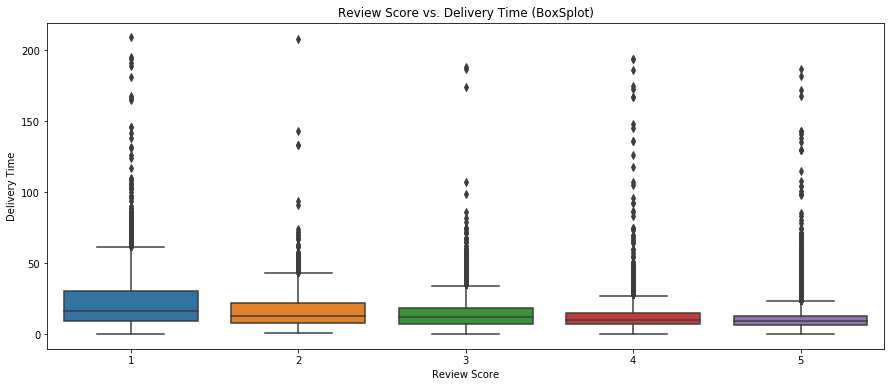

In [16]:
plt.figure(figsize=(15,6))
sns.boxplot(y = 'time_duration', x='review_score', data = df_orders)
#Modificación de Emmanuel para embellecer
#Inicio(4)
title_string = "Review Score vs. Delivery Time (BoxSplot)" 
plt.ylabel("Delivery Time")
plt.xlabel("Review Score")
#Fin(4)
_=plt.title(title_string)

Evidenciamos que a pesar que el score 5 en los reviews presenta más registros que los otros valores, en promedio el maximo tiempo de duración para las cinco calificaciones es 7 días. Otro dato relevante es que para el caso de un score de 1 y 2, parece que la distribución a lo largo de la duración de entrega es constante, pareciendo que pueden haber otras razones aparte de la duración de entrga que influya en la calificación.


Por lo anterior, podría ser interesante preguntarnos el coeficiente de correlación entre el socre de review y el numero de dias de entrega del producto, lo cual calculamos acontinuación:
    

In [17]:
#productos MAS vendidos:
df_products = df_items.groupby('product_category_name_english')['order_id'].count().reset_index(drop = False)
df_products = df_products.sort_values(by = 'order_id', ascending = False).reset_index(drop = True)
top_products = df_products.head(10)
top_products

,product_category_name_english,order_id
0,bed_bath_table,11746
1,health_beauty,10612
2,sports_leisure,9647
3,furniture_decor,8965
4,computers_accessories,8283
5,housewares,7295
6,watches_gifts,6358
7,telephony,4874
8,auto,4656
9,garden_tools,4575


In [18]:
#productos menos vendidos:
df_products = df_items.groupby('product_category_name_english')['order_id'].count().reset_index(drop = False)
df_products = df_products.sort_values(by = 'order_id', ascending = True).reset_index(drop = True)
deep_10_products = df_products.head(10)
deep_10_products

,product_category_name_english,order_id
0,security_and_services,2
1,fashion_childrens_clothes,8
2,la_cuisine,14
3,cds_dvds_musicals,14
4,arts_and_craftmanship,25
5,home_comfort_2,30
6,flowers,33
7,fashion_sport,35
8,music,39
9,furniture_mattress_and_upholstery,41


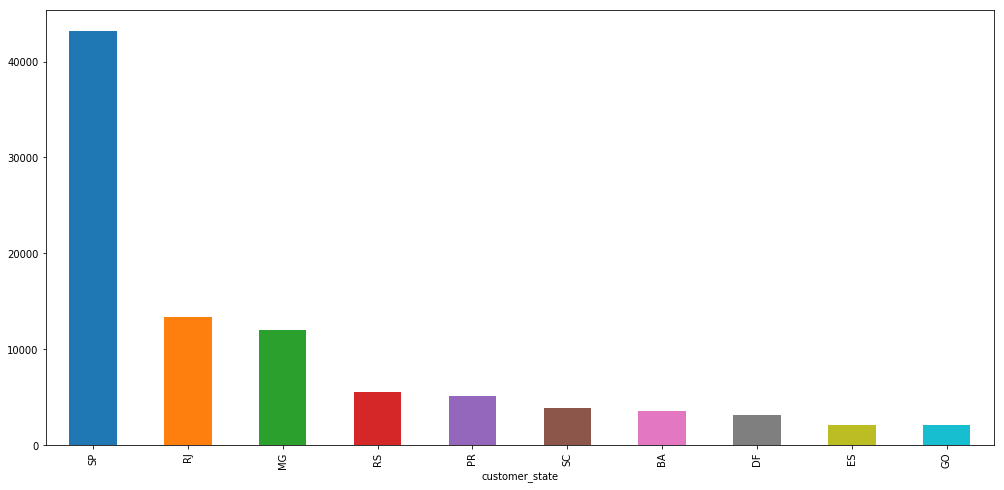

In [19]:
plt.figure(figsize=(17,8))
temp=df_orders.groupby('customer_state')['order_id'].count().sort_values(ascending=False).head(10).plot.bar()

Distribucion Reviews

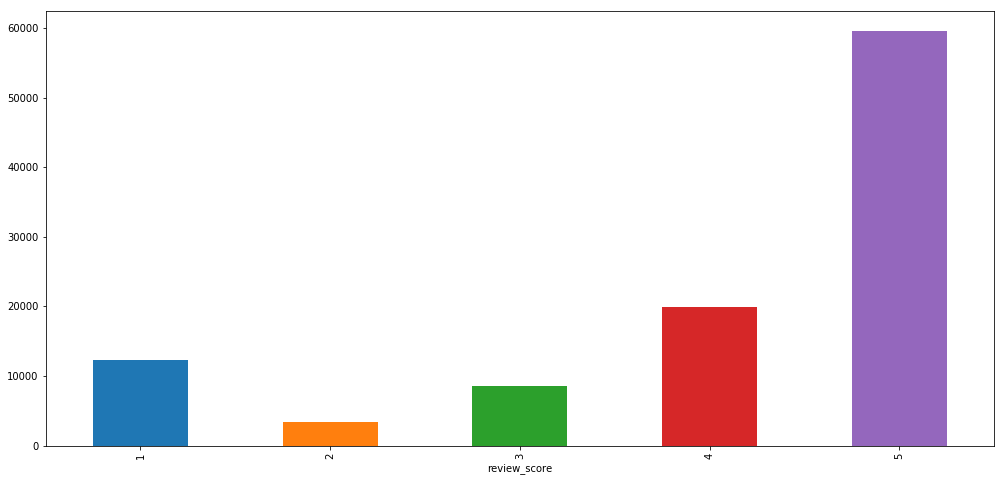

In [20]:
plt.figure(figsize=(17,8))
df_orders.groupby('review_score')['order_id'].count().plot.bar()

Cantidad de Clientes por cantidad de ordenes de cada cliente

(array([  8.98840000e+04,   5.24500000e+03,   6.82000000e+02,
          2.13000000e+02,   2.30000000e+01,   3.70000000e+01,
          5.00000000e+00,   4.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00]),
 array([  1.        ,   1.94117647,   2.88235294,   3.82352941,
          4.76470588,   5.70588235,   6.64705882,   7.58823529,
          8.52941176,   9.47058824,  10.41176471,  11.35294118,
         12.29411765,  13.23529412,  14.17647059,  15.11764706,
         16.05882353,  17.        ]),
 <a list of 17 Patch objects>)

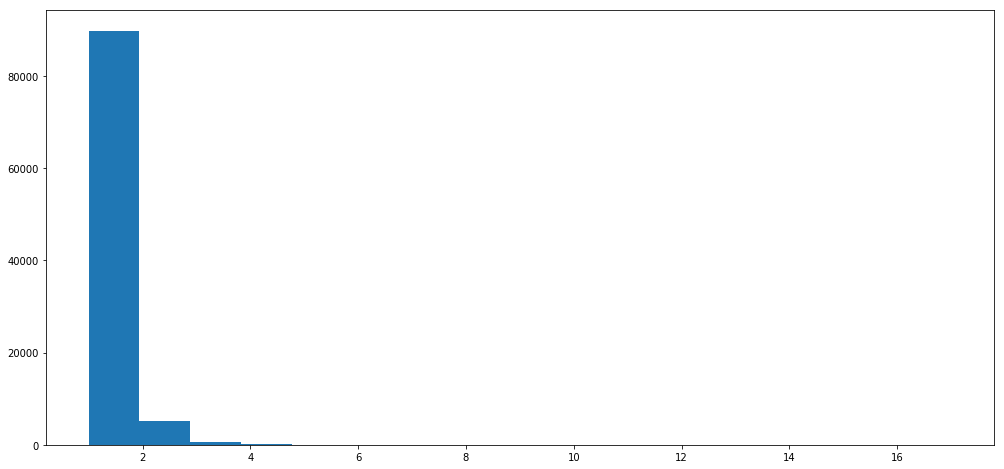

In [21]:
plt.figure(figsize=(17,8))
orders_client=df_orders.groupby('customer_unique_id')['order_id'].count().sort_values(ascending=False)
plt.hist(orders_client,17)

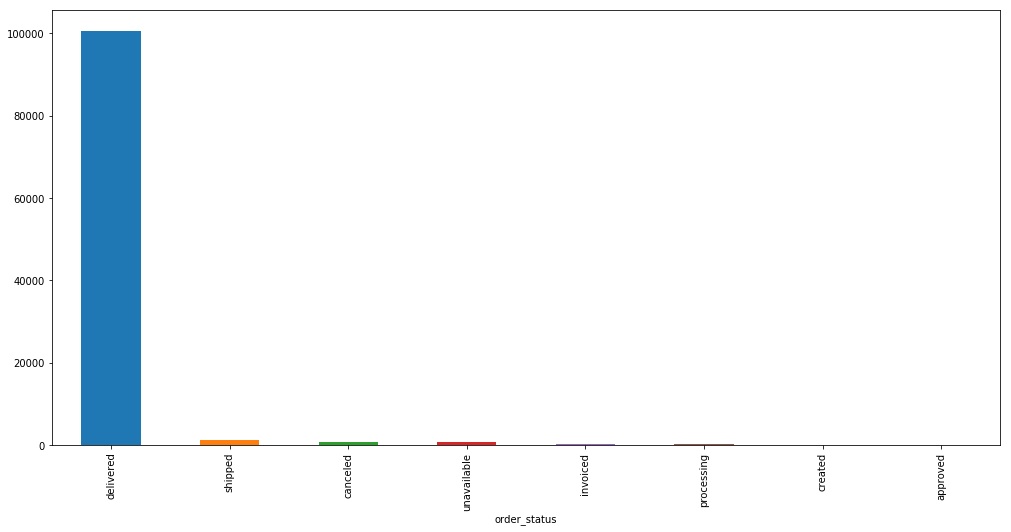

In [22]:
plt.figure(figsize=(17,8))
_=df_orders.groupby('order_status')['order_id'].count().sort_values(ascending=False).plot.bar()

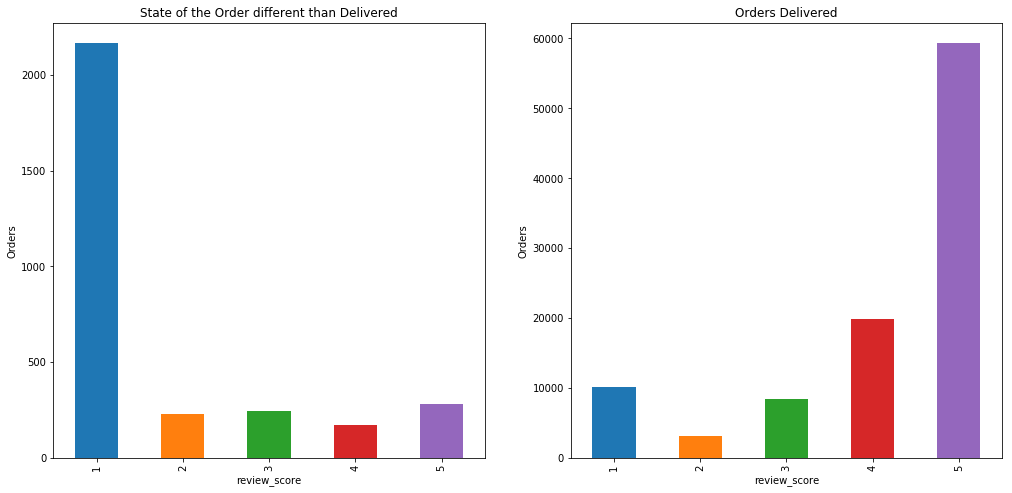

In [23]:
plt.figure(figsize=(17,8))
plt.subplot(121)
_=df_orders[df_orders.order_status!='delivered'].groupby('review_score')['order_id'].count().plot.bar()
plt.ylabel("Orders")
plt.xlabel="Review Score"
plt.title("State of the Order different than Delivered")
plt.subplot(122)
plt.ylabel("Orders")
plt.xlabel="Review Score"
plt.title("Orders Delivered")
_=df_orders[df_orders.order_status=='delivered'].groupby('review_score')['order_id'].count().plot.bar()

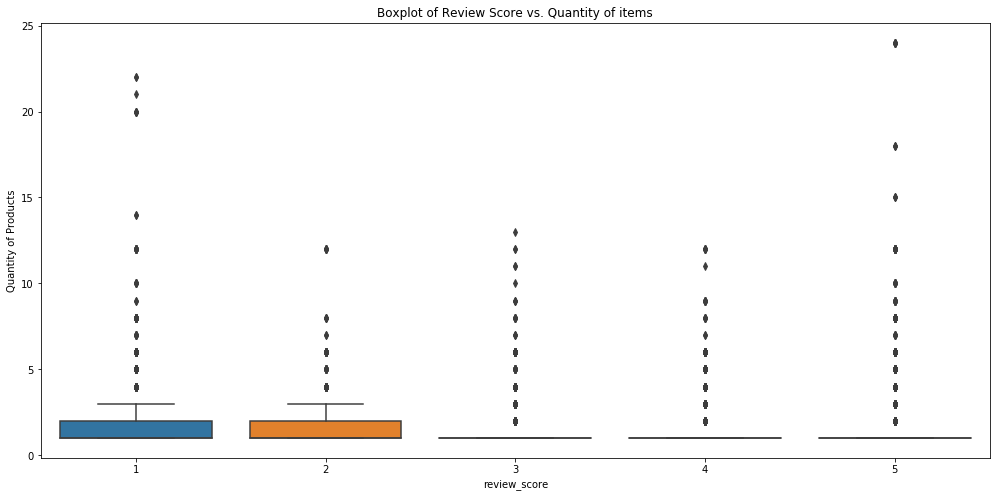

In [25]:
plt.figure(figsize=(17,8))
sns.boxplot(y = 'Q_products', x='review_score', data = df_orders)
title_string = "Boxplot of Review Score vs. Quantity of items" 
plt.ylabel("Quantity of Products")
_=plt.title(title_string)

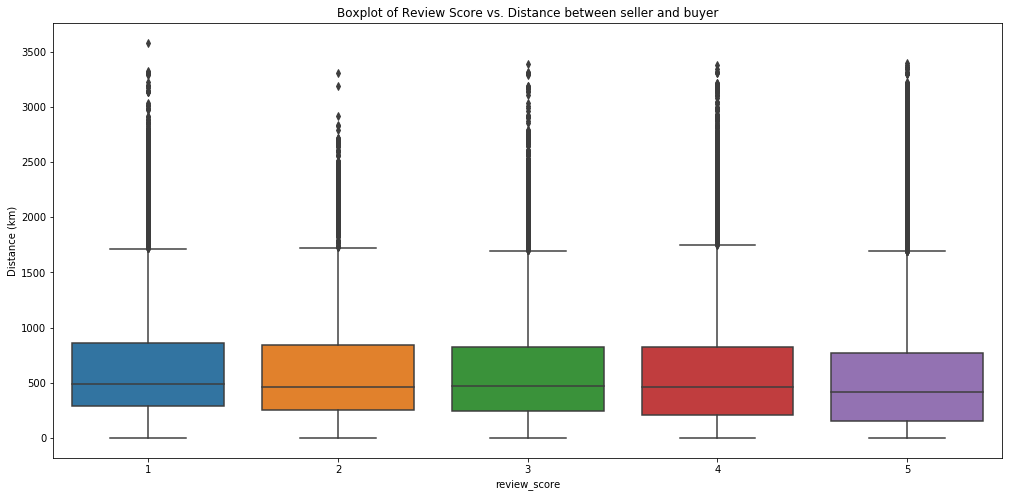

In [26]:
plt.figure(figsize=(17,8))
sns.boxplot(y = 'Distance', x='review_score', data = df_orders)
title_string = "Boxplot of Review Score vs. Distance between seller and buyer" 
plt.ylabel("Distance (km)")
plt.xlabel="Review Score"
_=plt.title(title_string)

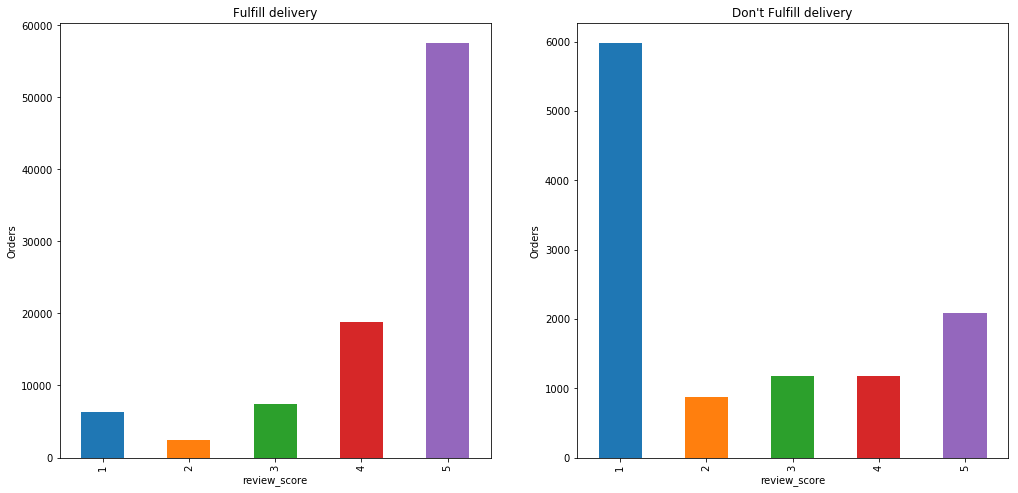

In [27]:
plt.figure(figsize=(17,8))
plt.subplot(121)
plt.title('Fulfill delivery')
plt.ylabel("Orders")
plt.xlabel="Review Score"
_=df_orders[df_orders.Fulfill_date==True].groupby('review_score')['order_id'].count().plot.bar()

plt.subplot(122)
plt.title("Don't Fulfill delivery")
plt.ylabel("Orders")
plt.xlabel="Review Score"
_=df_orders[df_orders.Fulfill_date==False].groupby('review_score')['order_id'].count().plot.bar()

In [29]:
statistic, pvalue = stats.ttest_ind(df_orders[df_orders.Fulfill_date==False].review_score,df_orders[df_orders.Fulfill_date==True].review_score, equal_var=False)
statistic, pvalue

(-124.32872192581453, 0.0)

In [34]:
mod = ols('review_score ~ order_status', data=df_orders).fit()  
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
order_status,17204.964357,7.0,1461.004205,0.0
Residual,174461.571193,103704.0,NaN,NaN


In [44]:
gb = df_orders.groupby(['order_status'])
group_names = df_orders["order_status"].unique()
print("\t\t\tstatistic\t\tpvalue")
len(group_names)
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        group1 = gb[["review_score"]].get_group(group_names[i])
        group2 = gb[["review_score"]].get_group(group_names[j])
        stat, pvalue = stats.ttest_ind(group1, group2, equal_var = False)
        print(group_names[i] + " vs. " + group_names[j] + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
delivered vs. canceled	43.2962841393	1.53078651313e-194
delivered vs. invoiced	35.4279584608	3.76065188117e-113
delivered vs. shipped	49.8481865392	1.686217109e-292
delivered vs. processing	63.9458261924	1.96736983829e-184
delivered vs. unavailable	56.5199698237	2.22566141694e-250
delivered vs. approved	1.09447217855	0.471302293298
delivered vs. created	2.9271047369	0.0429349467401
canceled vs. invoiced	1.69845525393	0.0898724482966
canceled vs. shipped	-3.04396043393	0.0023782476888
canceled vs. processing	7.59492331165	7.45058752039e-14
canceled vs. unavailable	3.60934680183	0.00031910856767
canceled vs. approved	-0.467389910146	0.721496776347
canceled vs. created	-0.00191871619058	0.998560173388
invoiced vs. shipped	-4.37808217521	1.42165352409e-05
invoiced vs. processing	4.58602806282	5.61588390953e-06
invoiced vs. unavailable	1.25162188852	0.211199673784
invoiced vs. approved	-0.567394347729	0.671107353689
invoiced vs. created	-0.189302277807	0.858939537981
sh

In [45]:
pairwise_results = pairwise_ttests(dv='review_score', between = ['order_status'], padjust='bonf', data=df_orders)
pairwise_results

AttributeError: 'Series' object has no attribute 'to_numpy'